In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

import akita_utils 
import pysam
import h5py
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-06-22 13:00:33.584093: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1310720, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1310720, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1310720, 4)   0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1310720, 4)   0           stochastic_shift[0][0]           
____________________________________________________________________________________________

(512, 130305, (130305,))

In [3]:
# with open('backround_seqs.fa','w') as f:
#     for i in range(len(flat_seqs)):
#         f.write('>seq'+str(i)+'_score'+str(int(flat_seqs[i][2]))+'_pixelwise'+str(int(flat_seqs[i][3]*1000))+'\n')
#         f.write(dna_io.hot1_dna(flat_seqs[i][0])+'\n')
       

# Fetching chromosome data to explore background creation

In [4]:
chromsizes = bioframe.read_chromsizes('/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced')
bins = bioframe.binnify(chromsizes, 1310720)
df = bioframe.frac_gc(bins, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)
df

,chrom,start,end,GC
0,chr1,0,1310720,NaN
1,chr1,1310720,2621440,NaN
2,chr1,2621440,3932160,0.386460
3,chr1,3932160,5242880,0.401122
4,chr1,5242880,6553600,0.393862
...,...,...,...,...
2085,chrY,86507520,87818240,0.392786
2086,chrY,87818240,89128960,0.390694
2087,chrY,89128960,90439680,0.384166
2088,chrY,90439680,91744698,0.417601


array([0.36257709, 0.36587454, 0.36817734, 0.37065207, 0.37299786,
       0.37570795, 0.37762457, 0.37970245, 0.38174762, 0.3842182 ,
       0.38629681, 0.38790781, 0.38917107, 0.3905381 , 0.39205158,
       0.3936232 , 0.3960943 , 0.39810775, 0.40056351, 0.40236493,
       0.40381584, 0.40533798, 0.40708984, 0.40936343, 0.41157089,
       0.41348972, 0.41546698, 0.41760017, 0.42007883, 0.42148009,
       0.42376548, 0.4263613 , 0.42851746, 0.42988721, 0.43299001,
       0.43606558, 0.4383895 , 0.44031067, 0.44245801, 0.44505133,
       0.447931  , 0.45059813, 0.45486053, 0.45826593, 0.46257977,
       0.46890153, 0.47304071, 0.47886063, 0.48705676, 0.50131308])

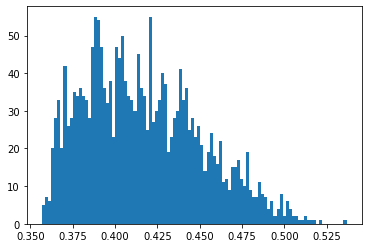

In [5]:
plt.hist( df['GC'].values, 100);
np.percentile(df['GC'].dropna().values, np.linspace(1,99,50))

# Generating a sample for down stream analysis

In [6]:
sample_set = []
error = 0.01
# print(df['GC'].dropna().values[0])

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,50)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            sample_set += [i]
            break

# print(set(sample_set), len(set(sample_set)))

sample_set = list(set(sample_set))

sample_set = sample_set[1:3]

print(sample_set)

predictions=[]

for ind in set(sample_set):
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    genome_open = pysam.Fastafile(genome_fasta)
    seq = genome_open.fetch(chrom, start, end).upper()
    seq_1hot = dna_io.dna_1hot(seq)
    predictions.append(seq_1hot)
    
predictions = np.array(predictions)
predictions = seqnn_model.predict(predictions, batch_size=6)#len(sample_set)
    

[3, 6]


2022-06-22 13:01:40.640980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-22 13:01:40.641725: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2593500000 Hz


In [7]:
flat_seqs = akita_utils.custom_create_flat_seqs(seqnn_model=seqnn_model, 
                                                genome_fasta=genome_fasta, 
                                                seq_length=seq_length, 
                                                dataframe=df, 
                                                sample_set=sample_set, 
                                                devisor = 3,  # iterations wil be tracked in multiples of this number
                                                max_iters = 10, 
                                                batch_size = 6, 
                                                shuffle_k = 8, 
                                                ctcf_thresh = 8, 
                                                scores_thresh = 5500, 
                                                scores_pixelwise_thresh = .04 )

3
ind 3 , iter  0 , for chr1 3932160 5242880
0
trying: best seq, thresh 4790.0  pixelwise 0.04636
ind 3 , iter  1 , for chr1 3932160 5242880
1
trying: best seq, thresh 4684.0  pixelwise 0.046
ind 3 , iter  2 , for chr1 3932160 5242880
1
success: best seq, thresh 4764.0  pixelwise 0.03662
max iters exceeded
6
ind 6 , iter  0 , for chr1 7864320 9175040
2
success: best seq, thresh 5010.0  pixelwise 0.03607
max iters exceeded


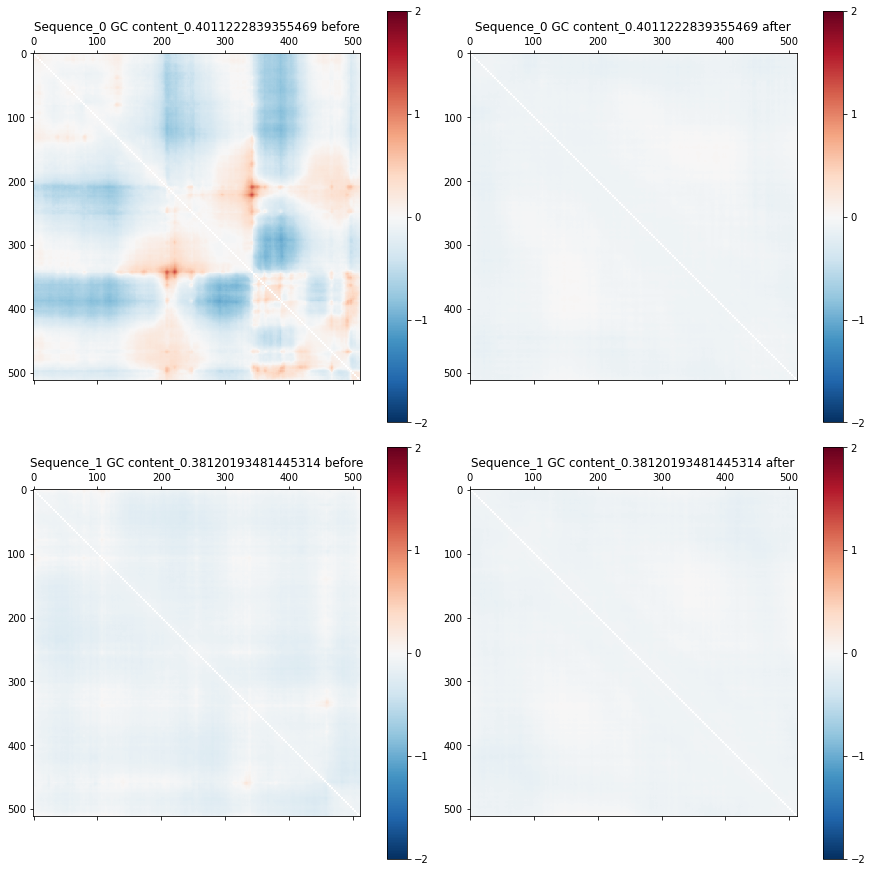

In [8]:
fig = plt.figure(figsize=(6* 2 , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=2, nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
target_ind = 0
vmin=-2; vmax=2

for i in range(len(sample_set)):
    
    flat_pred = flat_seqs[i,'final'][1]
    gc        = flat_seqs[i,'final'][-1]
    back_pred = predictions[i]

    mat = akita_utils.from_upper_triu(back_pred[:,target_ind], target_map_size,hic_diags)
    ax1 = fig.add_subplot(spec[i,0])
    im = ax1.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)# 
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
    plt.title(f'Sequence_{i} GC content_{gc} before')       
           
    mat = akita_utils.from_upper_triu(flat_pred[:,target_ind], target_map_size,hic_diags)
    ax2 = fig.add_subplot(spec[i,1])
    im = ax2.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)# 
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])       
    plt.title(f'Sequence_{i} GC content_{gc} after')       
        
plt.show()

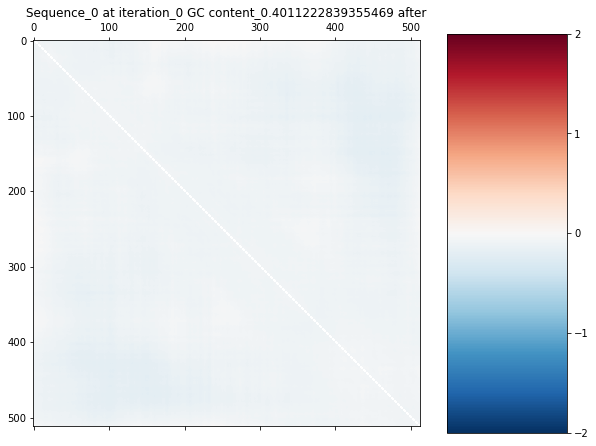

<Figure size 2592x432 with 0 Axes>

In [9]:
max_iters = 12
max_replicates = 6
           
target_ind = 0
vmin=-2; vmax=2

for i in range(len(sample_set)):
    j_counter = 0
    fig = plt.figure(figsize=(6*6 , 6), constrained_layout=True)     
    spec = fig.add_gridspec(ncols=max_replicates, nrows=1, hspace=0.1, wspace=0.1)
    for j in range(max_iters):
        if (i,j) in flat_seqs.keys():
            # print((i,j),(i_counter,j_counter))
    
            flat_pred = flat_seqs[i,j][1]
            gc        = flat_seqs[i,j][-1]

            mat = akita_utils.from_upper_triu(flat_pred[:,target_ind], target_map_size,hic_diags)
            ax2 = fig.add_subplot(spec[0,j_counter])
            im = ax2.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)# 
            plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])       
            plt.title(f'Sequence_{i} at iteration_{j} GC content_{gc} after')       

            j_counter += 1
    plt.show()
    plt.close()
    